# Analyse du risque de crédit avec German Credit Dataset

## Contexte
Ce projet utilise le dataset German Credit pour développer un modèle de scoring crédit. L'objectif est de prédire si un client présente un bon ou mauvais risque de crédit en se basant sur différentes caractéristiques.

## Objectifs
- Analyser les facteurs qui influencent l'octroi de crédit
- Développer un modèle de Decision Tree pour prédire le risque de crédit
- Évaluer la performance du modèle et identifier les variables les plus importantes

## Dataset  
Le **German Credit Dataset** contient 1000 entrées avec 20 variables explicatives incluant :  
- Informations personnelles (âge, statut matrimonial...)  
- Informations financières (historique de crédit, montant...)  
- Informations professionnelles (emploi, ancienneté...)  

Le dataset est disponible sur [Kaggle](https://www.kaggle.com/datasets/uciml/german-credit).


## 1. Importation des bibliothèques

In [123]:
import pandas as pd
from ucimlrepo import fetch_ucirepo
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_curve, auc,classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, accuracy_score
from imblearn.over_sampling import SMOTE
from scipy.stats import chi2_contingency
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

## 2. Chargement, exploration et prétraitement des données

In [124]:
statlog_german_credit_data = fetch_ucirepo(id=144)

X = statlog_german_credit_data.data.features
Y = statlog_german_credit_data.data.targets

df = pd.concat([X, Y], axis=1)
df2 = pd.read_csv("german_credit_data.csv")
df2.head()
df2["class"] = Y
df2.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,class
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,1
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,2
2,2,49,male,1,own,little,NaN,2096,12,education,1
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,1
4,4,53,male,2,free,little,little,4870,24,car,2


In [125]:
del df2["Unnamed: 0"]
print(df2.info())
df2.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   class             1000 non-null   int64 
dtypes: int64(5), object(5)
memory usage: 78.3+ KB
None


,Age,Job,Credit amount,Duration,class
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,1.904000,3271.258000,20.903000,1.300000
std,11.375469,0.653614,2822.736876,12.058814,0.458487
min,19.000000,0.000000,250.000000,4.000000,1.000000
25%,27.000000,2.000000,1365.500000,12.000000,1.000000
50%,33.000000,2.000000,2319.500000,18.000000,1.000000
75%,42.000000,2.000000,3972.250000,24.000000,2.000000
max,75.000000,3.000000,18424.000000,72.000000,2.000000


In [126]:
df2.isna().sum()

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
class                 0
dtype: int64

### Remplissage des données manquantes par la valeur la plus fréquente

In [127]:
df2["Saving accounts"].fillna(df2["Saving accounts"].mode()[0],inplace=True)
df2["Checking account"] = df2["Checking account"].fillna(df2["Checking account"]
                                                         .mode()[0])

C:\Users\YOUNESS\AppData\Local\Temp\ipykernel_12216\3739874771.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2["Saving accounts"].fillna(df2["Saving accounts"].mode()[0],inplace=True)


In [128]:
df2.isna().sum()

Age                 0
Sex                 0
Job                 0
Housing             0
Saving accounts     0
Checking account    0
Credit amount       0
Duration            0
Purpose             0
class               0
dtype: int64

In [129]:
df2.drop_duplicates(inplace=True)
df2.shape

(1000, 10)

In [130]:
numeric_columns = [i for i in df2 if (df2[i].dtype != object and i != "Job")]
print(numeric_columns)
categorial_columns   = [i for i in df2 if df2[i].dtype == object] + ["Job"]
print(categorial_columns)

['Age', 'Credit amount', 'Duration', 'class']
['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose', 'Job']


### Exploration des relations entre les variables numériques et la variable cible

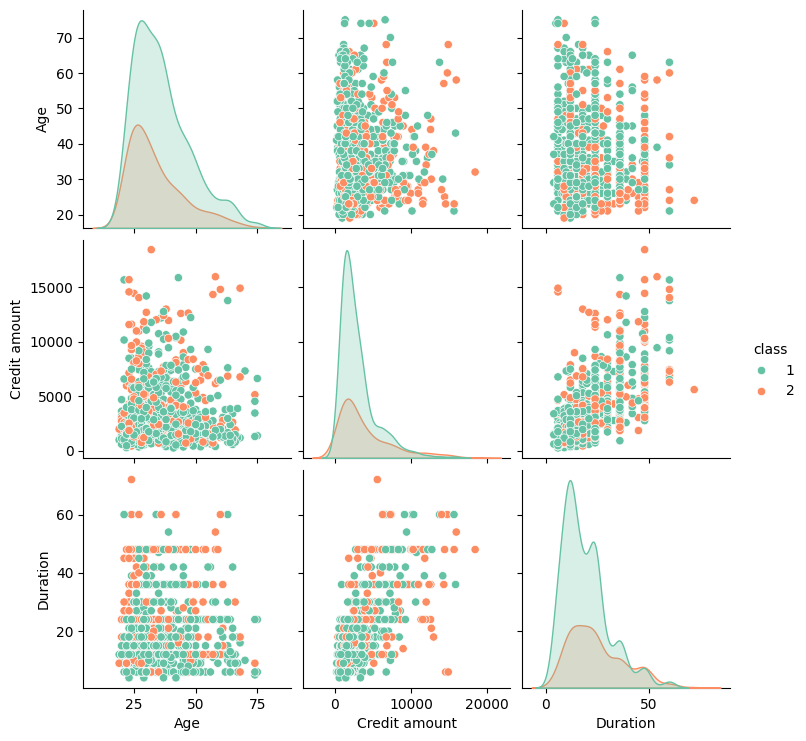

In [131]:
sns.pairplot(df2[numeric_columns],hue="class",palette="Set2")

### Étude de la corrélation pour les variables numériques

In [132]:
correlation_with_class = df2.loc[:, numeric_columns].corr()\
    ['class'].sort_values(ascending=False)

print(correlation_with_class)


class            1.000000
Duration         0.214927
Credit amount    0.154739
Age             -0.091127
Name: class, dtype: float64


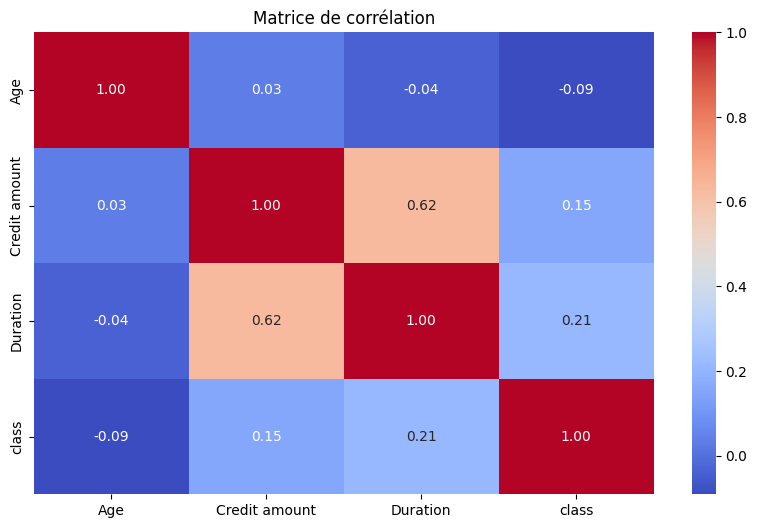

In [133]:

import matplotlib.pyplot as plt
correlation_matrix = df2[numeric_columns].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matrice de corrélation")
plt.show()

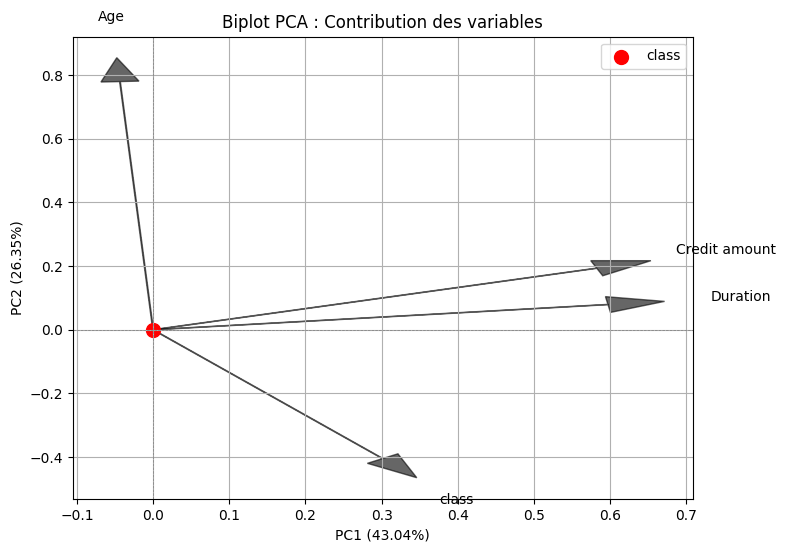

In [134]:
X = df2[numeric_columns]

# Standardiser les données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Appliquer ACP
pca = PCA(n_components=2)  
pca.fit(X_scaled)

loadings = pca.components_.T  # Matrice des vecteurs propres

fig, ax = plt.subplots(figsize=(8, 6))

for i, var in enumerate(X.columns):
    ax.arrow(0, 0, loadings[i, 0], loadings[i, 1], 
             color='black', alpha=0.6, head_width=0.05,
             length_includes_head=True)
    ax.text(loadings[i, 0] * 1.15, loadings[i, 1] * 1.15, var,
            color='black', ha='center', va='center')

ax.scatter(0, 0, color="red", s=100, label="class")

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)")
plt.title("Biplot PCA : Contribution des variables")
plt.axhline(0, color='grey', linestyle='--', linewidth=0.5)
plt.axvline(0, color='grey', linestyle='--', linewidth=0.5)
plt.legend()
plt.grid()
plt.show()


# Analyse des variables et recommandations de sélection
### D'après les visualisations présentées (matrice de corrélation et biplot PCA), nous pouvons faire plusieurs observations importantes pour la sélection des variables :
Le biplot PCA montre que les variables "Credit amount" et "Duration" pointent dans des directions similaires, indiquant une corrélation positive entre elles. Elles expliquent une part importante de la variance sur PC1 (43.04%). L'âge, quant à lui, contribue fortement à PC2 (26.35%) et semble indépendant des autres variables. La classe (variable cible) montre une relation négative avec l'âge.

### Étude de la corrélation pour les variables catégorielles

In [135]:

for col in categorial_columns:
    contingency_table = pd.crosstab(df2[col], df2['class'])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    print(f"Variable: {col}, p-value: {p:.4f}")

    if p < 0.05:
        print(f" {col} est significative pour la classification \n")
    else:
        print(f" {col} n'a pas d'influence forte sur la classification \n")


Variable: Sex, p-value: 0.0207
 Sex est significative pour la classification 

Variable: Housing, p-value: 0.0001
 Housing est significative pour la classification 

Variable: Saving accounts, p-value: 0.0042
 Saving accounts est significative pour la classification 

Variable: Checking account, p-value: 0.0006
 Checking account est significative pour la classification 

Variable: Purpose, p-value: 0.0579
 Purpose n'a pas d'influence forte sur la classification 

Variable: Job, p-value: 0.5966
 Job n'a pas d'influence forte sur la classification 



### Le choix des variables catégorielles et numériques

In [136]:
del df2["Purpose"]
del df2["Job"]
del df2["Age"]

In [137]:
df2.head()

,Sex,Housing,Saving accounts,Checking account,Credit amount,Duration,class
0,male,own,little,little,1169,6,1
1,female,own,little,moderate,5951,48,2
2,male,own,little,little,2096,12,1
3,male,free,little,little,7882,42,1
4,male,free,little,little,4870,24,2


In [138]:
encoded_df =  pd.get_dummies(df2, columns=['Housing',
                "Saving accounts","Checking account","Sex"]).astype(int)
encoded_df.head()

,Credit amount,Duration,class,Housing_free,Housing_own,Housing_rent,Saving accounts_little,Saving accounts_moderate,Saving accounts_quite rich,Saving accounts_rich,Checking account_little,Checking account_moderate,Checking account_rich,Sex_female,Sex_male
0,1169,6,1,0,1,0,1,0,0,0,1,0,0,0,1
1,5951,48,2,0,1,0,1,0,0,0,0,1,0,1,0
2,2096,12,1,0,1,0,1,0,0,0,1,0,0,0,1
3,7882,42,1,1,0,0,1,0,0,0,1,0,0,0,1
4,4870,24,2,1,0,0,1,0,0,0,1,0,0,0,1


In [139]:
y = encoded_df["class"]
del encoded_df["class"]

## 4. Séparation des données (Train/Test)

In [140]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(encoded_df, y, test_size=0.2)

## Optimisation des hyperparamètres du Decision Tree
Ce code réalise une recherche systématique des meilleurs hyperparamètres pour notre arbre de décision en utilisant GridSearchCV. Il teste différentes combinaisons de paramètres essentiels (profondeur maximale, nombre minimum d'échantillons pour diviser un nœud, nombre minimum d'échantillons dans une feuille) pour trouver la configuration optimale qui maximise l'accuracy du modèle. Une validation croisée à 5 plis est utilisée pour assurer la robustesse des résultats, et les performances sont visualisées via un graphique montrant l'accuracy moyenne et sa variance pour chaque combinaison de paramètres testée.
La visualisation finale permet d'identifier facilement les configurations les plus performantes et stables pour notre modèle de prédiction de risque de crédit.

Meilleurs paramètres : {'max_depth': 4, 'min_samples_leaf': 6, 'min_samples_split': 2}
Meilleur score d'accuracy : 0.70


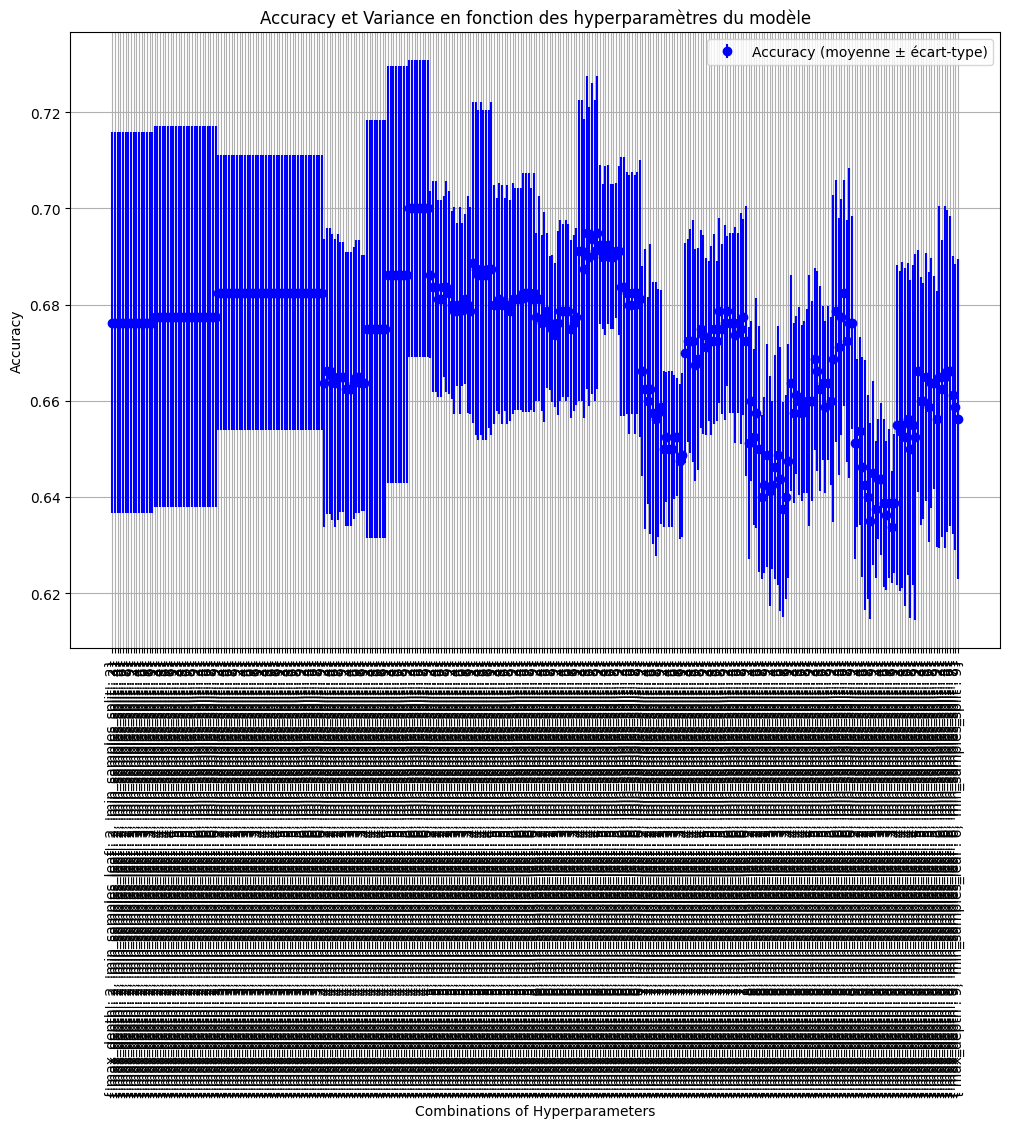

In [141]:
param_grid = {
    'max_depth': list(range(2,10)), 
    'min_samples_split': list(range(2,10)),
    'min_samples_leaf': list(range(2,7))  
}

clf = DecisionTreeClassifier()

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, 
                           scoring='accuracy', return_train_score=True)

grid_search.fit(X_train, y_train)

print(f"Meilleurs paramètres : {grid_search.best_params_}")
print(f"Meilleur score d'accuracy : {grid_search.best_score_:.2f}")

results = grid_search.cv_results_
best_model = grid_search.best_estimator_


mean_scores = results['mean_test_score']
std_scores = results['std_test_score']

params = results['params']

plt.figure(figsize=(12, 8))

plt.errorbar(range(len(mean_scores)), mean_scores,
             yerr=std_scores, fmt='o', color='blue', 
             label='Accuracy (moyenne ± écart-type)')

plt.xticks(range(len(mean_scores)), [str(param) for param in params], rotation=90)
plt.xlabel('Combinations of Hyperparameters')
plt.ylabel('Accuracy')
plt.title('Accuracy et Variance en fonction des hyperparamètres du modèle')
plt.grid(True)
plt.legend()
plt.show()


In [142]:
predictions = best_model.predict(X_test)
score  = best_model.score(X_test,y_test)
print(score)

0.705


# Analyse du rapport de classification

Ce rapport de performance présente les métriques clés de notre modèle de classification du risque de crédit :

## Interprétation par classe

### Classe 1 (Bon crédit) :
- **Précision** : 0.72 - 72% des prédictions de bon crédit sont correctes  
- **Recall** : 0.99 - 99% des bons crédits réels sont détectés  
- **F1-score** : 0.84 - Bonne moyenne harmonique entre précision et recall  
- **Support** : 139 cas  

### Classe 2 (Mauvais crédit) :
- **Précision** : 0.89 - 89% des prédictions de mauvais crédit sont correctes  
- **Recall** : 0.13 - Seulement 13% des mauvais crédits réels sont détectés  
- **F1-score** : 0.23 - Performance faible due au recall très bas  
- **Support** : 61 cas  

---

## Performance globale
- **Accuracy globale** : 0.73 (73% de prédictions correctes)  
- **Déséquilibre important** dans la détection des classes (*biais vers la classe majoritaire*)  

###  Note importante  
Le modèle est très bon pour identifier les bons crédits mais faible pour détecter les mauvais crédits, ce qui pourrait être problématique dans un contexte réel de gestion des risques.


In [143]:
report = classification_report(y_test, predictions)
print(report)

              precision    recall  f1-score   support

           1       0.73      0.91      0.81       141
           2       0.50      0.20      0.29        59

    accuracy                           0.70       200
   macro avg       0.62      0.56      0.55       200
weighted avg       0.66      0.70      0.66       200



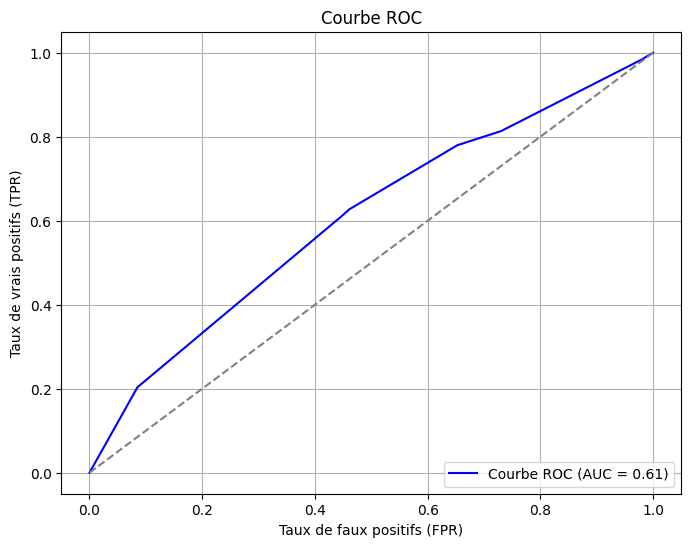

In [144]:
y_prob = best_model.predict_proba(X_test)[:, 1]  

fpr, tpr, thresholds = roc_curve(np.array(y_test) -1, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'Courbe ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--') 
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Analyse de la courbe ROC

## Description de la courbe  
Cette courbe ROC (*Receiver Operating Characteristic*) illustre la performance de notre modèle de classification avec une **AUC** (*Area Under the Curve*) de **0.66**.  

## Interprétation  

### AUC = 0.66 :
- Le modèle est **légèrement meilleur** qu'un classifieur aléatoire (*0.5*).  
- Cependant, la performance reste **modeste**, car une bonne AUC devrait être **> 0.8**.  

### Forme de la courbe :
- La courbe **s'écarte de la diagonale** (ligne pointillée) qui représente une prédiction aléatoire.  
- La progression **n'est pas très marquée**, suggérant un **compromis difficile** entre vrais positifs et faux positifs.  
- La courbe **monte rapidement** au début, puis progresse plus lentement.  


# Conclusion Globale et Améliorations
Le projet de classification utilisant un **DecisionTreeClassifier** sur le dataset **German Credit Risk**, avec l'optimisation des hyperparamètres via **GridSearchCV**, a permis de construire un modèle **interprétable et performant** pour prédire le risque de crédit. Les résultats montrent que l'arbre de décision est capable de **classer les clients avec une précision raisonnable**, tout en offrant une **transparence dans les règles de décision**. Cependant, malgré l'optimisation des paramètres, le modèle peut encore souffrir de certaines limitations, notamment liées à la nature du dataset, qui est volumineux et potentiellement **déséquilibré**, ainsi qu'à la difficulté de capturer des **relations complexes** avec un simple arbre de décision. Pour améliorer le modèle, plusieurs approches peuvent être envisagées. L'utilisation de **méthodes d'ensemble** comme **Random Forest** ou **Gradient Boosting** (*XGBoost, LightGBM*) permettrait de mieux gérer la complexité des données et **réduire le sur-ajustement**. Un travail sur le **Feature Engineering**, en sélectionnant et transformant les variables, pourrait également améliorer la performance du modèle. De plus, la gestion du **déséquilibre des classes** via des techniques comme **SMOTE**. Enfin, l'intégration d'outils d'interprétation comme **SHAP** faciliterait la compréhension des prédictions et leur explicabilité auprès des parties prenantes. En appliquant ces stratégies, le modèle pourrait gagner en **robustesse, généralisation et pertinence**, offrant ainsi une meilleure aide à la décision pour l’évaluation du risque de crédit.
